## Part 2 New Data [5 Pt]

### Part (i) [3pt RESULTS]

Retrieve sample pictures from online and demonstrate how well your best model performs. Provide all your code, including any image processing that you need to perform, and provide outputs on all the greyscale images you tested. Your outputs should show the greyscale images, ground truth, and model generated image.

In [1]:
# !pip 

```python
# Main training loop for UNet
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001,
    "batch_size": 10,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)
```

In [ ]:
import torch.nn as nn
import torch

from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt


import torch
class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Conv2d(num_filters, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
        )

        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*4, num_filters, kernel_size=kernel, stride=stride, padding=padding, output_padding=output_padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Conv2d(num_filters, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
        )
        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*2, num_colours, kernel_size=kernel, stride=stride, padding=padding, output_padding=output_padding),
            nn.BatchNorm2d(num_colours),
            nn.ReLU(),
        )
        self.finalconv = nn.Conv2d(num_colours, num_colours, kernel_size=kernel, padding=padding)

    def forward(self, x):
        x1 = self.downconv1(x)
        x2 = self.downconv2(x1)
        x3 = self.rfconv(x2)
        x4 = self.upconv1(torch.cat([x3, x2], 1))
        x5 = self.upconv2(torch.cat([x4, x1], 1))
        out = self.finalconv(x5)
        return out




# Replace with the values you used when training the model
kernel_size = 3  # Example value
num_filters_value = 32  # Example value

# Step 1: Load your trained model
model_path = 'outputs/colourization_cnn/final_model_regression_20231103211731_UNet_colourization_cnn.pth'  # Replace with your .pth file path
model = UNet(kernel_size,num_filters_value )  # Replace with your model class
model.load_state_dict(torch.load(model_path))


model.eval()  # Set the model to evaluation mode

# Step 2: Define the image preprocessing
# These transforms will need to match the ones you used during training
preprocess = transforms.Compose([
    transforms.Resize(256),  # Example, adjust to your needs
    transforms.CenterCrop(224),  # Example, adjust to your needs
    transforms.ToTensor(),
    # You might need normalization if you used it during training
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


#Load and process the image
url = 'https://onlinejpgtools.com/images/examples-onlinejpgtools/mountain-scene.jpg'
response = requests.get(url)
original_image = Image.open(BytesIO(response.content))
greyscale_image = original_image.convert('L')

# Apply the preprocess to the greyscale image
input_tensor = preprocess(greyscale_image)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Run the model and get the colorized image
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients for inference
    output = model(input_batch)

# Convert the output tensor to an image
output_image = output.squeeze().cpu().detach()
output_image = transforms.ToPILImage()(output_image)

# Visualize the images side by side
visualize_images(original_image, greyscale_image, output_image)



#Load and process the image
url = 'https://upload.wikimedia.org/wikipedia/commons/b/ba/Flower_jtca001.jpg'
response = requests.get(url)
original_image = Image.open(BytesIO(response.content))
greyscale_image = original_image.convert('L')

# Apply the preprocess to the greyscale image
input_tensor = preprocess(greyscale_image)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Run the model and get the colorized image
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients for inference
    output = model(input_batch)

# Convert the output tensor to an image
output_image = output.squeeze().cpu().detach()
output_image = transforms.ToPILImage()(output_image)

# Visualize the images side by side
visualize_images(original_image, greyscale_image, output_image)



### Generator

In [4]:


def visualize_images(original, greyscale, colorized):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(greyscale, cmap='gray')
    axes[1].set_title('Grayscale Image')
    axes[1].axis('off')
    
    axes[2].imshow(colorized)
    axes[2].set_title('Colorized Image')
    axes[2].axis('off')

    plt.show()



```python
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator",
    "kernel": 3,
    "num_filters": 16,
    'lr':0.001,
    "batch_size": 50,
    "epochs": 100,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
    "use_mps": True, 
}
args.update(args_dict)
cnn = train(args)
```

In [5]:
class Generator(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Conv2d(num_filters, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
        )

        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*4, num_filters, kernel_size=kernel, stride=stride, padding=padding, output_padding=output_padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Conv2d(num_filters, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
        )
        self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*2, num_colours, kernel_size=kernel, stride=stride, padding=padding, output_padding=output_padding),
            nn.BatchNorm2d(num_colours),
            nn.ReLU(),
        )
        self.finalconv = nn.Conv2d(num_colours, num_colours, kernel_size=kernel, padding=padding)

    def forward(self, x):
        x1 = self.downconv1(x)
        x2 = self.downconv2(x1)
        x3 = self.rfconv(x2)
        # print(x3.shape, x2.shape)
        # print(x2.shape)
        x4 = self.upconv1(torch.cat([x3, x2], 1))
        x5 = self.upconv2(torch.cat([x4, x1], 1))
        out = self.finalconv(x5)
        return out


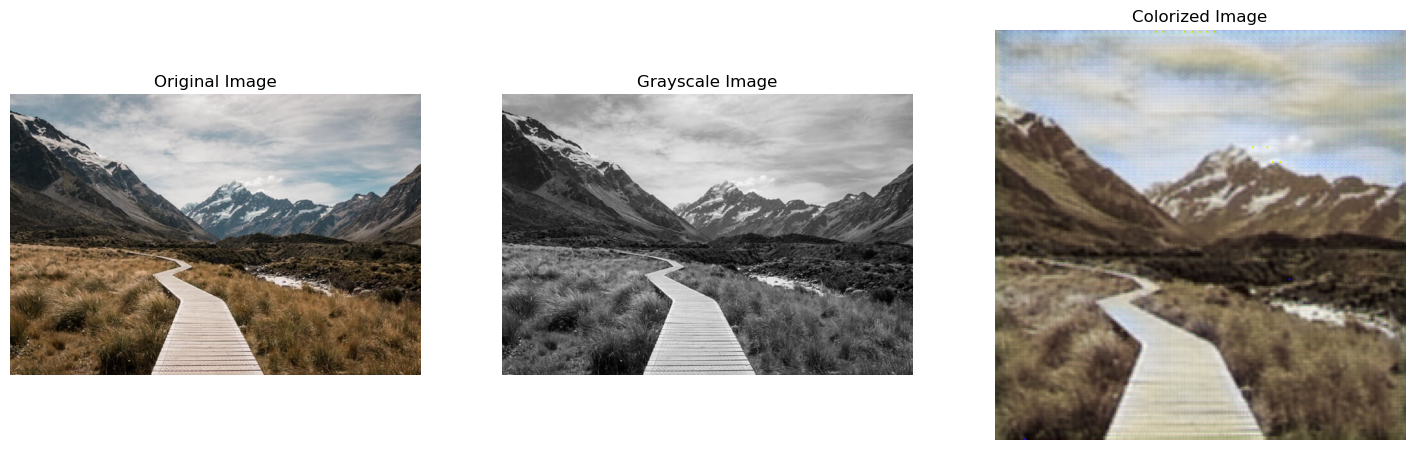

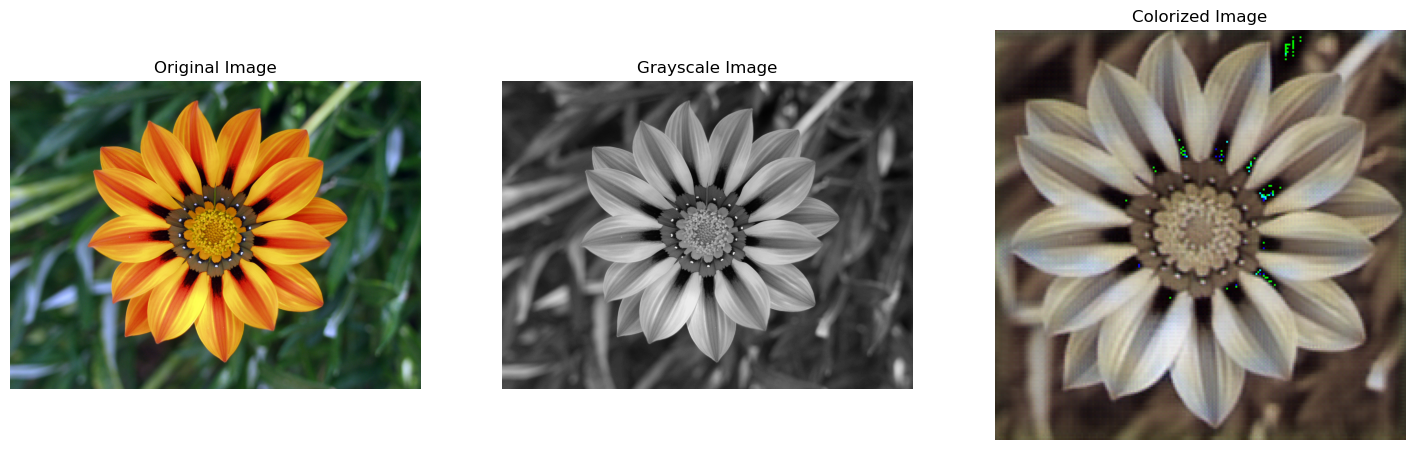

In [6]:

# Replace with the values you used when training the model
kernel_size = 3  # Example value
num_filters_value = 32  # Example value
# Step 1: Load your trained model
model_path = 'outputs/colourization_cnn/final_model_regression_20231103213511_Generator_colourization_cnn.pth'  # Replace with your .pth file path
model = Generator(kernel_size,num_filters_value )  # Replace with your model class
model.load_state_dict(torch.load(model_path))


model.eval()  # Set the model to evaluation mode

# Step 2: Define the image preprocessing
# These transforms will need to match the ones you used during training
preprocess = transforms.Compose([
    transforms.Resize(256),  # Example, adjust to your needs
    transforms.CenterCrop(224),  # Example, adjust to your needs
    transforms.ToTensor(),
    # You might need normalization if you used it during training
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


#Load and process the image
url = 'https://onlinejpgtools.com/images/examples-onlinejpgtools/mountain-scene.jpg'
response = requests.get(url)
original_image = Image.open(BytesIO(response.content))
greyscale_image = original_image.convert('L')

# Apply the preprocess to the greyscale image
input_tensor = preprocess(greyscale_image)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Run the model and get the colorized image
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients for inference
    output = model(input_batch)

# Convert the output tensor to an image
output_image = output.squeeze().cpu().detach()
output_image = transforms.ToPILImage()(output_image)

# Visualize the images side by side
visualize_images(original_image, greyscale_image, output_image)



#Load and process the image
url = 'https://upload.wikimedia.org/wikipedia/commons/b/ba/Flower_jtca001.jpg'
response = requests.get(url)
original_image = Image.open(BytesIO(response.content))
greyscale_image = original_image.convert('L')

# Apply the preprocess to the greyscale image
input_tensor = preprocess(greyscale_image)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Run the model and get the colorized image
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to track gradients for inference
    output = model(input_batch)

# Convert the output tensor to an image
output_image = output.squeeze().cpu().detach()
output_image = transforms.ToPILImage()(output_image)

# Visualize the images side by side
visualize_images(original_image, greyscale_image, output_image)


